D:\Anaconda\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


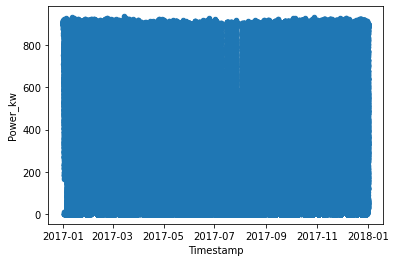

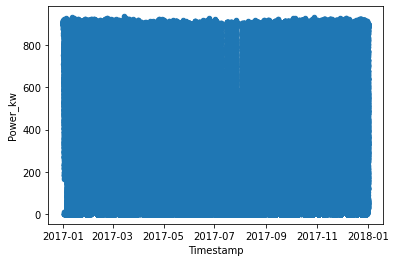

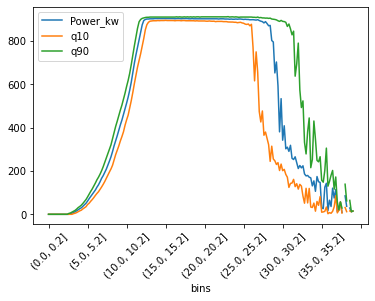

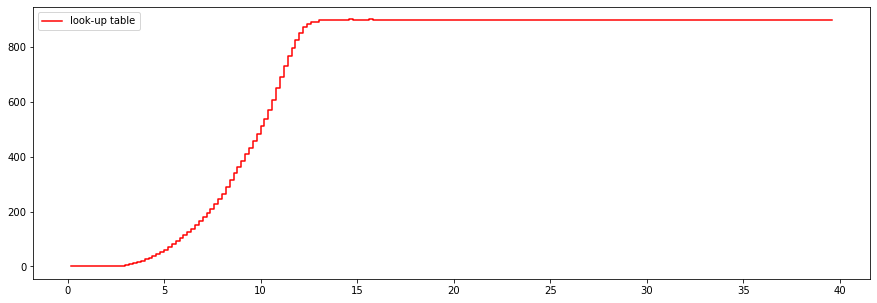

In [3]:

"""
Created on Fri Feb  5 18:07:23 2021

@author: Mary
topic: " explore data"
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

import numbers


##########################
##Fill in the 2017 April Data
##########################
def get_filed_2017_from_2016():
    turbine_telemetry_Qian = pd.read_csv('turbine_telemetry.csv', parse_dates=[0], index_col=0)
    turbine_telemetry_Qian = turbine_telemetry_Qian.reset_index()
    turbine_telemetry_Qian.Timestamp = pd.to_datetime(turbine_telemetry_Qian.Timestamp)
    turbine_telemetry_Qian['Year'] = turbine_telemetry_Qian.Timestamp.dt.year
    turbine_telemetry_Qian['Month'] = turbine_telemetry_Qian.Timestamp.dt.month
    turbine_telemetry_Qian['Day'] = turbine_telemetry_Qian.Timestamp.dt.day
    turbine_telemetry_Qian['Hour'] = turbine_telemetry_Qian.Timestamp.dt.hour
    turbine_telemetry_Qian['Minute'] = turbine_telemetry_Qian.Timestamp.dt.minute
    turbine_telemetry_Qian['Second'] = turbine_telemetry_Qian.Timestamp.dt.second
    
    
    grouped_df = turbine_telemetry_Qian.groupby(['Year','Month'])
    grouped_df = grouped_df.agg({'Day': 'nunique'})
    grouped_df = grouped_df.reset_index()
    location = grouped_df.Year == 2017
    grouped_df.loc[location]
    # The data in April is missing
    
    grouped_df = turbine_telemetry_Qian.groupby(['Year','Month','Day'])
    grouped_df = grouped_df.agg({'Hour': 'nunique'})
    grouped_df = grouped_df.reset_index()
    location = (grouped_df.Year == 2017) & (grouped_df.Month == 4)
    grouped_df.loc[location]
    # The data for April 3rd and April 24th are partially missing, and the data for April 4th to April 23 are entirely missing
    
    # Fill in the missing data for April 3th to April 24.
    # Replace the missing data in 2017 by data in 2016
    masks = (turbine_telemetry_Qian.Year == 2016) &  (turbine_telemetry_Qian.Month == 4) & (turbine_telemetry_Qian.Day.between(3, 24, inclusive=True))
    data_2016_for_replacement = turbine_telemetry_Qian.loc[masks]
    data_2016_for_replacement.Year = 2017
    data_2016_for_replacement.Timestamp = data_2016_for_replacement.Timestamp + pd.offsets.DateOffset(years=1)
    data_2016_for_replacement
    
    turbine_telemetry_filing_in_3_24 = turbine_telemetry_Qian.append(data_2016_for_replacement)
    turbine_telemetry_filing_in_3_24

    # reprint all the data from 2017
    tt_17  = turbine_telemetry_filing_in_3_24.copy()
    mask17 = (tt_17.Year == 2017)
    tt_17  = tt_17[mask17]
    
    tt17 = tt_17.copy()
    tt17 = tt17.reset_index()
    plot_filled_data = tt17.plot.scatter('Timestamp', 'Power_kw')


    return tt17



##############################
##Brin all to xx:00 second and take the mean values
##############################
# all the data from 2017


def isnumber(x):
    return isinstance(x, numbers.Number)

def not_number_to_nan(row):
    power = row.Power_kw
    if isnumber(power):
        return power
    else: 
        return np.nan

def get_all_zero_seconds_avg(tt17):

    tt_17 = tt17.copy()
    tt_17 = tt_17.reset_index()
    tt_17.plot.scatter('Timestamp', 'Power_kw')
        
    tt_17.Timestamp = tt_17.Timestamp.map(lambda x: x.replace(second=0))
    tt_17["Power_kw"] = tt_17.apply( not_number_to_nan, axis =1)
    
    #tt17_na_num = tt17_mean_data.isna().sum()

    
    tt17_mean_data = tt17.groupby("Timestamp").mean()
    
    return tt17_mean_data

#######################
## Main
#######################


tt = pd.read_csv('turbine_telemetry.csv', parse_dates=[0], index_col=0)

tt17 = get_filed_2017_from_2016()

tt17_mean_data = get_all_zero_seconds_avg(tt17)


###################################3
#### Q1
###################################

##Assumptions

turbines = 500
turbines_operating = 0.8 ## assumption

orkney_households = 9240

#tt = tt17_mean_data.copy()
#tt = tt.reset_index()


###################################3
####  1st way
###################################

def calcucate_curtailed_energy_setpoint_based(tt):

    turbine_telemetry_filter_wind_power = tt.copy()
    turbine_telemetry_filter_wind_power.loc[turbine_telemetry_filter_wind_power.Wind_ms >= 30, "Power_kw"] = 0

    max_setpoints_per_wind = turbine_telemetry_filter_wind_power.groupby('Wind_ms')['Setpoint_kw'].max()

    turbine_telemetry_filter_wind_power = turbine_telemetry_filter_wind_power.merge( max_setpoints_per_wind, on = "Wind_ms")

    turbine_telemetry_filter_wind_power = turbine_telemetry_filter_wind_power.rename(columns = {"Setpoint_kw_x": "Setpoint_kw", "Setpoint_kw_y": "Max_possible_setpoint" }) 

    turbine_telemetry_filter_wind_power["Setpoint_delta"] = turbine_telemetry_filter_wind_power["Max_possible_setpoint"] - turbine_telemetry_filter_wind_power["Setpoint_kw"]


    turbine_telemetry_filter_wind_power["Power_curtailed"] = turbine_telemetry_filter_wind_power["Setpoint_delta"]
    turbine_telemetry_filter_wind_power.loc[ turbine_telemetry_filter_wind_power.Setpoint_kw > turbine_telemetry_filter_wind_power.Power_kw , "Power_curtailed"] = 0

    total_curtailed_kwh = turbine_telemetry_filter_wind_power["Power_curtailed"].sum()/60

    total_curtailed_energy = turbines * turbines_operating * total_curtailed_kwh

    return total_curtailed_energy, turbine_telemetry_filter_wind_power




###################################3
#### 2nd way : curtailed = (possible power - island demand - export)*t
###################################

def get_wind_power_relation(tt):
    # how to figure out what's the the smallest speed necessary to produce power
    v_min = tt[(tt.loc[:, 'Power_kw'] >= 5.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile
    
    
    #df = pd.read_csv('turbine_telemetry.csv', parse_dates=[0], index_col=0)
    df = tt.query('Setpoint_kw==900').copy()
    
    # remove data points when the wind speed is fast enough for power production but there is no power;
    df.loc[((df.Wind_ms >= v_min) & (df.Power_kw.abs() <= 1e-5))] = np.nan
    
    # remove all missing values from the dataframe
    df = df.dropna(0, inplace=False)
    
    #####################################
    ## select bin locations
    #####################################
    wmax_ = df[df.Power_kw == df.Power_kw.quantile(0.90)].Wind_ms.quantile(0.5)
    wmax  = df.Wind_ms.max()
    
    
    bins = np.arange(0, wmax, .2)
    
    # group data by bins
    df['bins'] = pd.cut(df.Wind_ms, bins) #
    
    df_ = df[['Power_kw', 'bins']].groupby('bins')
    power_med = df_.quantile(0.5)
    power_med['q10'] = df_.quantile(0.1)
    power_med['q90'] = df_.quantile(0.9)
    
    
    # pretty good replication of the power vs wind profile
    plot_power = power_med.plot(rot=45)
    
    
    df['bins'].isna().sum()
    bin_nan = df[df["bins"].isna()]
    
    #####################################
    # look-up table mean and standard deviation
    #####################################
    
    # group data by bins
    cuts = pd.cut(df.Wind_ms, bins)
    gp_  = df.Power_kw.groupby(cuts) # iterator
    
    lutm = gp_.mean()
    luts = gp_.std()
    
    # convert to an interval index
    lutm.index = pd.IntervalIndex(lutm.index)
    luts.index = pd.IntervalIndex(luts.index)
    # this is the basis of our look-up table
    
    
    # round power to nearest 5 watts == 0.05 kW
    lutm = lutm.round(2)
    
    # set final power output to 900
    lutm.loc[wmax_:] = 900
    
    # make zero interval open at both ends to cover zero wind speed
    lutm.loc[pd.Interval(0,.2, closed='right')] = 0 
    
    
    #####################################
    # extend range to gusts of wind that are greater than max operating speed (25m/s) but of short duration
    #####################################
    #lutm.loc[pd.Interval(wmax_, 50, closed='right')] = 900
    #lutm.loc[pd.IntervalIndex.get_indexer_non_unique(lutm.loc[pd.Interval(25, 50)])] = 0


    
    # compare lookup table with data
    plt.figure(figsize=(15,5))
    s = plt.step(lutm.index.right, lutm, color='r')
    plt.legend(s, ['look-up table'], loc='upper left')
    
    #########################################
    gp = df
    mask = (gp.index.year == 2017)
    gp_17 = gp[mask]
    
    
    possible_power = [ 0 if pd.isnull(bini) else lutm[bini] for bini in gp_17.bins  ]
    gp_17 = gp_17.assign(Max_power_available = possible_power)
    

    return gp_17,lutm


#####################################
### Calculate the demand
#####################################

def get_demand_data():
    
    demand = pd.read_csv('residential_demand.csv', parse_dates=[0], index_col=0)
    mask   = (demand.index.year == 2017)
    demand = demand[mask]
    
    demand["Mean_demand"] = demand["Demand_mean_kw"]/demand["N_households"]

    return demand

def calculate_curtailed_energy_mean_demand(gp_17, demand):
    
    gp_17 = gp_17.reset_index()
    gp_17["Timestamp"] = gp_17["Timestamp"].apply(lambda x: pd.Timestamp.replace(x,second=0) )
    gp_17 = gp_17.set_index("Timestamp")
    
    
    curtailed = gp_17.join(demand, how = "outer")
    curtailed = curtailed.drop(columns = ["N_households","Demand_mean_kw", "Wind_ms", "bins"])
    curtailed.index.sort_values()
    
    
    curtailed['Mean_demand']   = curtailed['Mean_demand'].interpolate(method='linear')
    curtailed["island_demand"] = curtailed["Mean_demand"]*orkney_households
    
    
    curtailed_power = curtailed.copy()
    curtailed_power["power_excess"] = turbines_operating*turbines*curtailed["Max_power_available"] - curtailed["island_demand"] - 40000
    curtailed_power = curtailed_power.drop(columns = ["Power_kw","Setpoint_kw", "Max_power_available","Mean_demand"])
    
    curtailed_power.loc[curtailed_power['power_excess'] < 0, 'power_excess'] = 0
    
    total_curtailed_energy_kwh = curtailed_power["power_excess"].sum()/60

    return total_curtailed_energy_kwh, curtailed_power



total_curtailed_energy_1way, turbine_telemetry_filter_wind_power = calcucate_curtailed_energy_setpoint_based(tt17_mean_data)
gp_17,lutm = get_wind_power_relation(tt17_mean_data)
demand = get_demand_data()
total_curtailed_energy_2nd, curtailed_power = calculate_curtailed_energy_mean_demand(gp_17, demand)

In [4]:
demand
curtailed_power
turbine_telemetry_filter_wind_power
print(total_curtailed_energy_2nd/10**9)

1.1096934439868105


In [5]:
demand.reset_index()


,Timestamp,Demand_mean_kw,N_households,Mean_demand
0,2017-01-01 00:00:00,0.220106,5428,0.000041
1,2017-01-01 00:30:00,0.205945,5429,0.000038
2,2017-01-01 01:00:00,0.189090,5429,0.000035
3,2017-01-01 01:30:00,0.173118,5429,0.000032
4,2017-01-01 02:00:00,0.159051,5429,0.000029
...,...,...,...,...
17515,2017-12-31 21:30:00,0.309426,17360,0.000018
17516,2017-12-31 22:00:00,0.289606,17360,0.000017
17517,2017-12-31 22:30:00,0.266376,17360,0.000015
17518,2017-12-31 23:00:00,0.263845,17360,0.000015


In [6]:
resc_heating_usage.head()
combined_table_2


DR_penetration_perc = 0.1

resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')
Udemand=demand.reset_index()
Ucurtailed_power=curtailed_power.reset_index()

combined_table = pd.merge(Udemand,Ucurtailed_power, how ='left',on=['Timestamp']) 
combined_table = pd.merge(combined_table,resc_heating_usage, how ='left',on=['Hour','Minute']) 

combined_table

NameError: name 'resc_heating_usage' is not defined

In [ ]:
# The following step is to define percentage of household use DR system for heating
DR_penetration_perc = 0.1


def saved_curtailmend_power(DR_penetration_perc):
    # import new dataset
    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')
    Udemand=demand.reset_index()
    Ucurtailed_power=curtailed_power.reset_index()
    
    # Merge and filter table

    combined_table_2 = pd.merge(Udemand,Ucurtailed_power, how ='left',on=['Timestamp']) 
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 
    DR_penetration_num= orkney_households*DR_penetration_perc
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]

    #calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=orkney_households

    combined_table_2['household_with_DR']=DR_penetration_num

    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']

    # replace negative/NaN saved curtailment energy by 0

    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)


    #Print yearly_saved_energy(mwh)
    yearly_saved_energy = pd.DataFrame(combined_table_2.groupby(['Month'])['saved_curtailment_kwh'].sum())
    return yearly_saved_energy
    


In [ ]:
saved_curtailmend_power(0.1)

In [95]:
    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')
    Udemand=demand.reset_index()
    Ucurtailed_power=curtailed_power.reset_index()

    combined_table_2 = pd.merge(Udemand,Ucurtailed_power, how ='left',on=['Timestamp']) 
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 


    combined_table_2=combined_table_2[ (combined_table_2['Month']== DR_month_1) | (combined_table_2['Month']== DR_month_2)  | (combined_table_2['Month']== DR_month_3)  ] 
combined_table_2

,Timestamp,Demand_mean_kw,N_households,Mean_demand,index,Year,Month,Day,Hour,Minute,Second,island_demand,power_excess,res_heating_perc
0,2017-01-01 00:00:00,0.220106,5428,0.000041,558731.0,2017.0,1.0,1.0,0.0,0.0,20.0,0.374684,318795.625316,0.526316
1,2017-01-01 00:30:00,0.205945,5429,0.000038,558761.0,2017.0,1.0,1.0,0.0,30.0,20.0,0.350513,319547.649487,0.403158
2,2017-01-01 01:00:00,0.189090,5429,0.000035,558791.0,2017.0,1.0,1.0,1.0,0.0,20.0,0.321825,319999.678175,0.280000
3,2017-01-01 01:30:00,0.173118,5429,0.000032,558821.0,2017.0,1.0,1.0,1.0,30.0,20.0,0.294642,319999.705358,0.248696
4,2017-01-01 02:00:00,0.159051,5429,0.000029,558851.0,2017.0,1.0,1.0,2.0,0.0,20.0,0.270700,319999.729300,0.217391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17657,2017-12-31 21:30:00,0.309426,17360,0.000018,1054730.0,2017.0,12.0,31.0,21.0,30.0,32.0,0.164694,85855.835306,0.162500
17658,2017-12-31 22:00:00,0.289606,17360,0.000017,1054760.0,2017.0,12.0,31.0,22.0,0.0,32.0,0.154145,114015.845855,0.200000
17659,2017-12-31 22:30:00,0.266376,17360,0.000015,1054790.0,2017.0,12.0,31.0,22.0,30.0,32.0,0.141781,31575.858219,0.323684
17660,2017-12-31 23:00:00,0.263845,17360,0.000015,1054820.0,2017.0,12.0,31.0,23.0,0.0,32.0,0.140433,37643.859567,0.447368


In [92]:
# The following step is used to define monthes that DR heater is going to turn on.
DR_month_1=12
DR_month_2=11
DR_month_3=1
float(DR_month_3)


def saved_curtailmend_power_seasonal(DR_penetration_perc,DR_month_1,DR_month_2,DR_month_3):

    resc_heating_usage = pd.read_csv('Add_residential_heating_demand_perc.csv')
    Udemand=demand.reset_index()
    Ucurtailed_power=curtailed_power.reset_index()

    combined_table_2 = pd.merge(Udemand,Ucurtailed_power, how ='left',on=['Timestamp']) 
    combined_table_2 = pd.merge(combined_table_2,resc_heating_usage, how ='left',on=['Hour','Minute']) 


    combined_table_2=combined_table_2[ (combined_table_2['Month']== DR_month_1) | (combined_table_2['Month']== DR_month_2)  | (combined_table_2['Month']== DR_month_3)  ] 

    # add residential heating electricity assumption into combine dataframe
    DR_penetration_num= orkney_households*DR_penetration_perc
    combined_table_2=combined_table.copy()
    combined_table_2=combined_table_2[['Timestamp','Demand_mean_kw','N_households','res_heating_perc','power_excess','Year','Month','Hour','Minute']]

    #calculate additional residential electicity usage by installing DR system
    combined_table_2['N_households']=orkney_households

    combined_table_2['household_with_DR']=DR_penetration_num

    combined_table_2['addi_demand_by_DR_kwh']=0.5*combined_table_2['household_with_DR']*combined_table_2['Demand_mean_kw']*combined_table_2['res_heating_perc']

    # replace negative/NaN saved curtailment energy by 0

    combined_table_2['saved_curtailment_kwh']= combined_table_2[['addi_demand_by_DR_kwh','power_excess']].min(axis=1)
    combined_table_2['saved_curtailment_kwh'] = combined_table_2['saved_curtailment_kwh'].fillna(0)


    #Print yearly_saved_energy(mwh)
    yearly_saved_energy = pd.DataFrame(combined_table_2.groupby(['Year'])['saved_curtailment_kwh'].sum())
    return yearly_saved_energy
    


In [93]:
saved_curtailmend_power_seasonal(0.1,1,2,3)


,saved_curtailment_kwh
Year,
2017.0,190684.781912


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Saved curtailment energy at different penetration level')

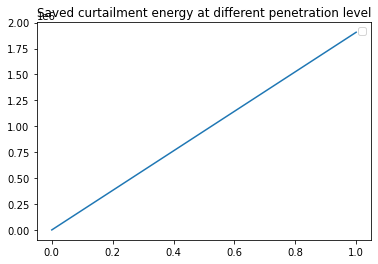

In [77]:
# Draw the graph of different energy saving of different penetration level
#def draw_saved_energy_penetration(start,end):

n=0
saved_energy_of_different_penetration=list()
for i in range(0,11):
    DR_penetration_perc = i/10
    DR_penetration_num= 10000*DR_penetration_perc

    #Print yearly_saved_energy(mwh)
    combined_table_draw_1 = saved_curtailmend_power(DR_penetration_perc)
    yearly_saved_energy = pd.DataFrame(combined_table_draw_1.groupby(['Year'])['saved_curtailment_kwh'].sum())
    val=yearly_saved_energy.iloc[0]['saved_curtailment_kwh']
    saved_energy_of_different_penetration.append(val)

#print(saved_energy_of_different_penetration)

x=[round(x*0.1,1) for x in range(0,11)]
y=saved_energy_of_different_penetration
plt.plot(x,y)
plt.legend()
plt.title("Saved curtailment energy at different penetration level")


ValueError: x and y must have same first dimension, but have shapes (11,) and (20,)

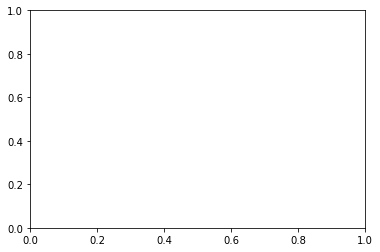

In [75]:
draw_saved_energy_penetration(0,1)